In [1]:
import numpy as np
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Read the HP5 file
hf = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_rnn.h5', 'r')

In [3]:
a = len(list(hf.keys())) - 3

In [4]:
def readsave(arg1,arg2):
  n1 = np.array(arg1[arg2][:])
  return n1

In [5]:
n = np.array([])
for i in range(a):
  n1 = readsave(hf,list(hf.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[0,:,:,0].reshape(n1.shape[0]**2)
  n1 = n1[:,np.newaxis]
  if i == 0:
    n = n1
  else:
    n = np.append(n,n1,axis=1)
    #print(n.shape)

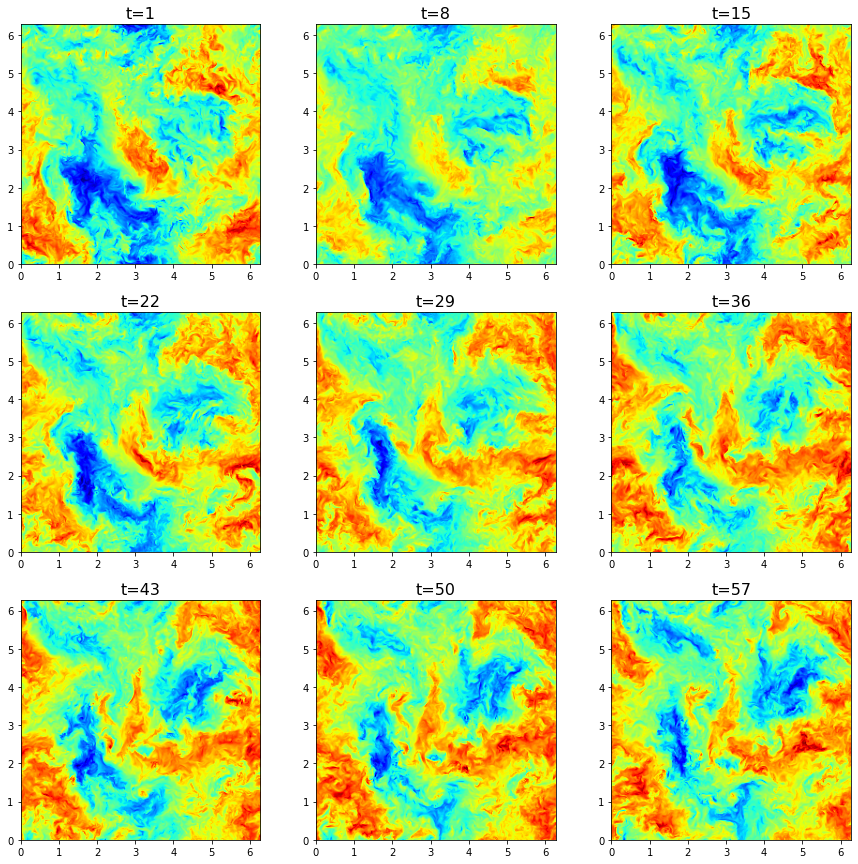

In [6]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,7):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

In [7]:
#Setup Input and Output that is separated by one step
nn_input = n[:,0:-1].transpose()
nn_output = n[:,1:].transpose()
print(nn_input.shape,nn_output.shape)

In [8]:
#Setup validation and demean all inputs
mean = nn_input.mean(axis=0,keepdims=True)

nn_im = nn_input - mean
nn_om = nn_output - mean
from sklearn.model_selection import train_test_split

all_indices = list(range(nn_input.shape[0]))

train, dev = train_test_split(all_indices, test_size=0.2)

nn_ipm = nn_im[train,:]
nn_idm = nn_im[dev,:]
nn_opm = nn_om[train,:]
nn_odm = nn_om[dev,:]

print(nn_ipm.shape, nn_opm.shape, nn_idm.shape, nn_odm.shape)

(63, 65536) (63, 65536)
(50, 65536) (50, 65536) (13, 65536) (13, 65536)


In [9]:
#Train NN to model this one timestep
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(1000, input_dim=nn_input.shape[1], activation='sigmoid'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(5000, activation='relu'))
deep_approx.add(layers.Dense(nn_output.shape[1], activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
History = deep_approx.fit(nn_ipm, nn_opm, epochs=500,
                          validation_data=(nn_idm, nn_odm))

Epoch 1/500
2/2 [==============================] - 4s 721ms/step - loss: 0.1289 - val_loss: 0.1310
Epoch 2/500
2/2 [==============================] - 0s 134ms/step - loss: 0.1169 - val_loss: 0.1154
Epoch 3/500
2/2 [==============================] - 0s 130ms/step - loss: 0.0934 - val_loss: 0.0902
Epoch 4/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0714 - val_loss: 0.0775
Epoch 5/500
2/2 [==============================] - 0s 136ms/step - loss: 0.0654 - val_loss: 0.0680
Epoch 6/500
2/2 [==============================] - 0s 130ms/step - loss: 0.0524 - val_loss: 0.0628
Epoch 7/500
2/2 [==============================] - 0s 132ms/step - loss: 0.0491 - val_loss: 0.0581
Epoch 8/500
2/2 [==============================] - 0s 129ms/step - loss: 0.0434 - val_loss: 0.0543
Epoch 9/500
2/2 [==============================] - 0s 135ms/step - loss: 0.0396 - val_loss: 0.0522
Epoch 10/500
2/2 [==============================] - 0s 134ms/step - loss: 0.0371 - val_loss: 0.0484
Epoch 11/

In [10]:
deep_approx.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              65537000  
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              10005000  
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             327745536 
Total params: 405,289,536
Trainable params: 405,289,536
Non-trainable params: 0
_________________________________________________________________


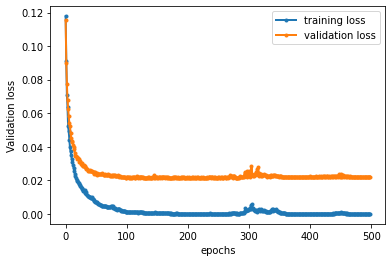

In [11]:
idx0 = 1
plt.figure()
plt.plot(History.history['loss'][idx0:], '.-', lw=2)
plt.plot(History.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [12]:
#Attempt reconstructing time trajectory
start = nn_im[0,:][np.newaxis,:]
t = nn_im.shape[0]
nn_pred = start

for i in range(t-1):
  nn_pred = np.append(nn_pred,deep_approx.predict(nn_pred[i,:][np.newaxis,:]),axis=0)

nn_pred = nn_pred + mean
nn_pred = nn_pred.transpose()

In [13]:
nn_pred.shape

(65536, 63)

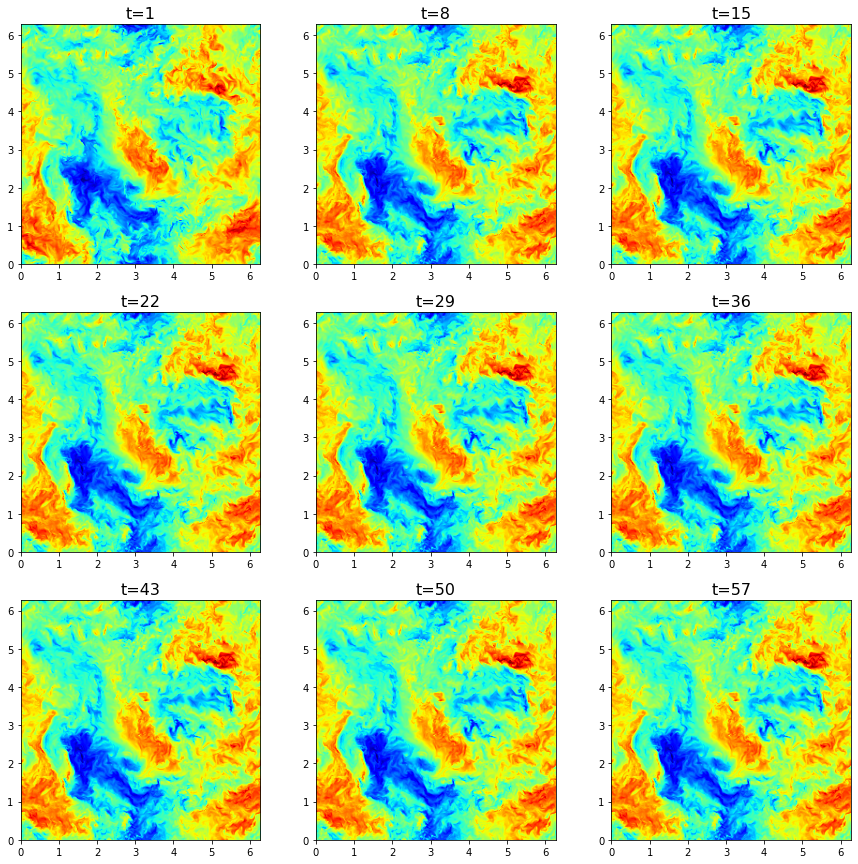

In [14]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,7):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

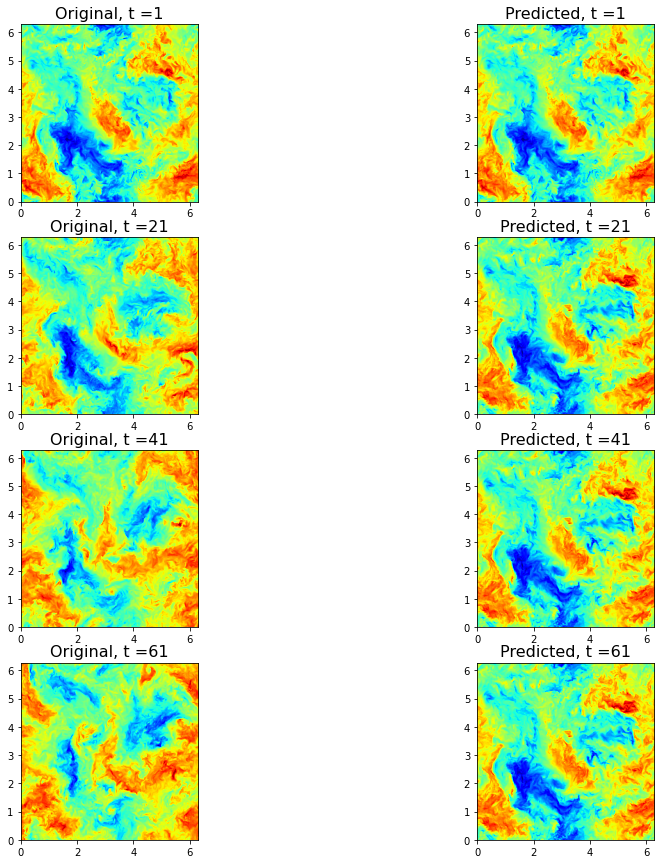

In [15]:
#Compare Actuals vs predicted
a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,20):
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Original, t =' + str(i+1),fontsize=16)
  
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Predicted, t =' + str(i+1),fontsize=16)